# Homework #7. kNN, K-Means

In [1]:
from collections import Counter
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
from sklearn import preprocessing

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
X, y = load_iris(return_X_y=True)
X = X[:, :2]
scaler = preprocessing.MinMaxScaler()
X_norm = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = \
model_selection.train_test_split(X, y, test_size=0.2, random_state=9)

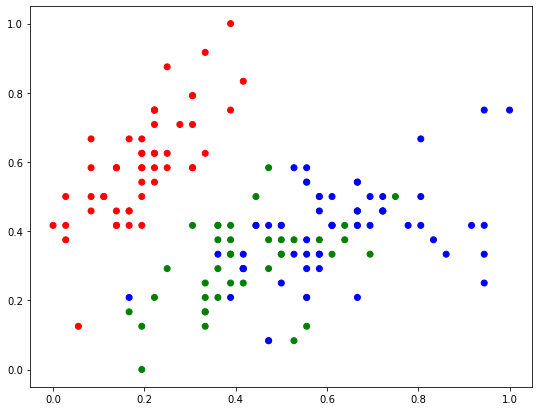

In [3]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(9, 7))
plt.scatter(X_norm[:, 0], X_norm[:, 1], c=y, cmap=cmap);

## Task #1

К алгоритму kNN, представленному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

In [4]:
def calc_dist_weight(distance, a, b):
    return 1 / ((distance + a) ** b)

In [5]:
def calc_euclidean_distance(x1, x2):
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])

    return np.sqrt(distance)

In [6]:
def search_point(x, clusters):
    ind = 0
    for c in clusters:
        if list(x) in c:
            return ind
        ind += 1
    return -1

In [7]:
def calc_mean_intra_distance(x, clusters):

    """
    :param x:  X_train object
    :param clusters:  list of lists where indexes are equivalent to a category from y_train
    :returns:  Mean Intra-Cluster Distance
    """

    a = 0
    ind = search_point(list(x), clusters)

    for i in clusters[ind]:
        if i == list(x):
            continue
        a += calc_euclidean_distance(x, i)
    cluster_size = len(clusters[ind]) - 1

    return a / cluster_size

In [8]:
def calc_mean_nearest_cluster_distance(x, clusters):

    """
    :param x:  X_train object
    :param clusters:  list of lists where indexes are equivalent to a category from y_train
    :returns:  Mean Nearest-Cluster Distance
    """

    b = []
    ind = search_point(x, clusters)

    for i in range(len(clusters)):
        if i == ind:
            continue
        tmp = 0
        for j in clusters[i]:
            tmp += calc_euclidean_distance(x, j)
        b.append(tmp / len(clusters[i]))

    if not b:
        return 0

    return min(b)

In [9]:
def accuracy(pred, y):
    return sum(y == pred) / len(y)

In [24]:
class KNN:
    def __init__(self, k=3, q=0.5):
        self.k = k
        self.q = q

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

        self.clusters = [list() for i in range(len(set(self.y_train)))]
        self.predicted_clusters = [list() for i in range(len(set(self.y_train)))]

        for i in range(len(y)):
            self.clusters[y[i]].append(list(X[i]))

    def predict(self, X):
        predicted_labels = [self._predict(x) for x in X]
        return np.array(predicted_labels)

    def _predict(self, x):

        classes = {class_item: 0 for class_item in set(self.y_train)}
        distances = []
        for i in range(len(self.X_train)):
            distance = (calc_euclidean_distance(x, self.X_train[i]), self.y_train[i])
            if distance[0]:
                distances.append(distance)
        k_neighbors = sorted(distances)[:self.k]
        
#         добавление весов
        for distance in k_neighbors:
            a = calc_mean_intra_distance(x, self.clusters)
            b = calc_mean_nearest_cluster_distance(x, self.clusters)
            classes[distance[1]] += calc_dist_weight(distance[0], a, b)

        pred = sorted(classes, key=classes.get)[-1]
        self.predicted_clusters[pred].append(list(x))
        return pred

In [18]:
clf = KNN(k=7)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

print(accuracy(prediction, y_test))


0.9333333333333333


## Task #2

(*) Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из этого урока (создать датасет, как в методичке).

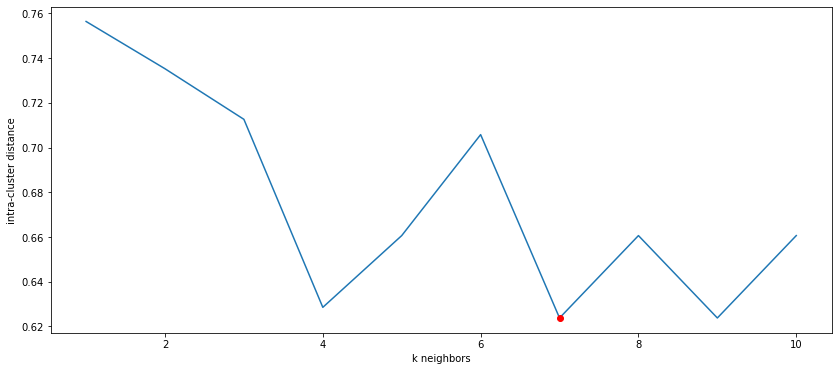

In [44]:
plt.figure(figsize=(14,6))

ks = np.arange(1, 11)
dists = []

for k in ks:
    clf = KNN(k=k)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)

    #   calculate mean intra-cluster distance
    mean_intra_distance = \
    np.array([calc_mean_intra_distance(list(x), clf.predicted_clusters) for x in X_test]).mean()
    dists.append(mean_intra_distance)
    
plt.plot(ks, dists);
ind = dists.index(min(dists))
plt.plot(ks[ind], min(dists), 'ro')
plt.xlabel('k neighbors')
plt.ylabel('intra-cluster distance');

<p style='background-color:red;color:white;padding:6px'>Что-то я не уверена, что здесь всё так, как должно быть. Будет интересно получить замечания, т.к. это мой максимум.